In [1]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 
import evaluate
import random

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


## Preprocess our data

In [2]:
data_train = pd.read_csv('./emotions_data/emotion-labels-train.csv') 
data_test = pd.read_csv('./emotions_data/emotion-labels-test.csv')
data_val = pd.read_csv('./emotions_data/emotion-labels-val.csv')

In [3]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [4]:
data_test.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [5]:
data_val.head()

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy
3,@tomderivan73 😁...I'll just people watch and e...,joy
4,I love my family so much #lucky #grateful #sma...,joy


In [6]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)
data

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
7097,Common app just randomly logged me out as I wa...,sadness
7098,"I'd rather laugh with the rarest genius, in be...",sadness
7099,If you #invest in my new #film I will stop ask...,sadness
7100,"Just watched Django Unchained, Other people ma...",sadness


In [7]:
data['text_clean'] = data['text'].apply(lambda x: clean(x, no_emoji=True))
data

# why: So that the model does not learn from characters or names that are not relevant to the emotional content of the text.

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing @garydelaney in burs...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game #cheer #fr...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,"@gardiner_love : thank you so much, gloria! yo..."
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
...,...,...,...
7097,Common app just randomly logged me out as I wa...,sadness,common app just randomly logged me out as i wa...
7098,"I'd rather laugh with the rarest genius, in be...",sadness,"i'd rather laugh with the rarest genius, in be..."
7099,If you #invest in my new #film I will stop ask...,sadness,if you #invest in my new #film i will stop ask...
7100,"Just watched Django Unchained, Other people ma...",sadness,"just watched django unchained, other people ma..."


In [8]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('@[^\s]+', '', x))
data.head(20)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game #cheer #fr...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,": thank you so much, gloria! you're so sweet,..."
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"today i reached 1000 subscribers on yt!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"good morning, love! happy first day of fall. ..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#bridgetjonesbaby is the best thing i've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
9,@IndyMN I thought the holidays could not get a...,joy,i thought the holidays could not get any more...


<Axes: xlabel='label'>

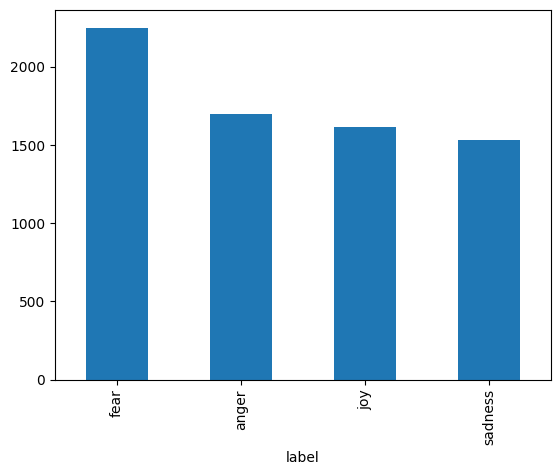

In [9]:
data['label'].value_counts().plot(kind="bar")

In [10]:
g = data.groupby('label')
for label, group in g:
    print(f"Label: {label}")
    print(group)

Label: anger
                                                   text  label   
1970  How the fu*k! Who the heck! moved my fridge!.....  anger  \
1971  So my Indian Uber driver just called someone t...  anger   
1972  @DPD_UK I asked for my parcel to be delivered ...  anger   
1973  so ef whichever butt wipe pulled the fire alar...  anger   
1974  Don't join @BTCare they put the phone down on ...  anger   
...                                                 ...    ...   
7023  @Jen_ny69 People will always get offended ever...  anger   
7024  @gayla_weeks1 I try not to let my anger seep i...  anger   
7025               I hope my hustle don't offend nobody  anger   
7026  Just watched Django Unchained, Other people ma...  anger   
7027     Lol little things like that make me so angry x  anger   

                                             text_clean  
1970  how the fu*k! who the heck! moved my fridge!.....  
1971  so my indian uber driver just called someone t...  
1972   i asked for m

In [11]:
# x represents the current group (a small DataFrame for one label).
# x.sample(g.size().min()) randomly selects the same number of rows from each group, equal to the size of the smallest group.

# anger → randomly selects 1533  out of 1701 rows
# fear → randomly selects 1533  out of 2252 rows
# joy → randomly selects 1533  out of 1616 rows
# sadness →  keeps all 1533 rows
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

# why: To prevent the model from learning more from labels that have more examples, which could cause bias

<Axes: xlabel='label'>

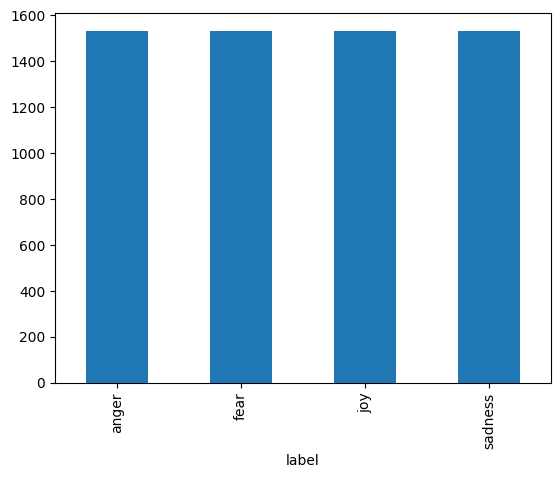

In [12]:
data['label'].value_counts().plot(kind="bar")

In [13]:
# Converts the text labels (e.g. anger, joy, fear, sadness) into integer labels (0–3) so they can be used by a model.
## fit – למידה     ## transform – המרה
data['label_int'] = LabelEncoder().fit_transform(data['label'])
data

text    label   
label                                                                      
anger   0     Sorry guys I have absolutely no idea what time...    anger  \
        1     Or when they hmu on snap, and I'm like.. which...    anger   
        2     Is it me, or is Ding wearing the look of a man...    anger   
        3                                       Don't be bitter    anger   
        4      @LeonWobYP b***er off. NCFC is a grudge match :)    anger   
...                                                         ...      ...   
sadness 1528  This is the @Fender #blues #junior. I'm lookin...  sadness   
        1529              Feels grim not having your nails done  sadness   
        1530  I get embarrassed at the slightest things and ...  sadness   
        1531  “The immense importance of football is sometim...  sadness   
        1532  Trying to think positive, and not let this sit...  sadness   

                                                     text_clean  label_int  
label                                                                       
anger   0     sorry guys i have absolutely no idea what time...          0  
        1     or when they hmu on snap, and i'm like.. which...          0  
        2     is it me, or is ding wearing the look of a man...          0  
        3                                       don't be bitter          0  
        4                 b***er off. ncfc is a grudge match :)          0  
...                                                         ...        ...  
sadness 1528  this is the  #blues #junior. i'm looking forwa...          3  
        1529              feels grim not having your nails done          3  
        1530  i get embarrassed at the slightest things and ...          3  
        1531  "the immense importance of football is sometim...          3  
        1532  trying to think positive, and not let this sit...          3  

[6132 rows x 4 columns]

In [14]:
NUM_LABELS = 4

In [15]:
train_split, test_split = train_test_split(data, train_size = 0.8)
train_split, val_split = train_test_split(train_split, train_size = 0.9)

# Train → to train the model
# Validation → to evaluate the model during training (tune parameters, prevent overfitting)
# Test → to assess the final performance on data the model has never seen before

In [16]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [17]:
train_split

,,text,label,text_clean,label_int
label,,,,,
fear,1487,"@CGasparino Give it up Gas, I don't hate u, I ...",fear,"give it up gas, i don't hate u, i just don't ...",1
anger,24,@leepg \n\nLike a rabid dog I pulled out the b...,anger,\nlike a rabid dog i pulled out the backs of m...,0
fear,880,Just had to reverse half way up the woods to c...,fear,just had to reverse half way up the woods to c...,1
joy,1403,"@ruthwalford95 you may be right, but since yea...",joy,"you may be right, but since year the bad even...",2
anger,7,@AgentTinsley I believe that's what you call t...,anger,i believe that's what you call the fury of th...,0
...,...,...,...,...,...
joy,861,"@ClaireBlair27 See, that's how you and Michell...",joy,"see, that's how you and michelle are so cheery!",2
fear,1458,@JustinTrudeau opened doors to terrorism and h...,fear,opened doors to terrorism and he will pay for...,1
joy,640,Omg. You've got to watch the new series 'This ...,joy,omg. you've got to watch the new series 'this ...,2


In [18]:
test_split

,,text,label,text_clean,label_int
label,,,,,
anger,1451,13 hour @bus rides make me #sorry,anger,13 hour rides make me #sorry,0
fear,1138,@vibaby @imEB y'all had crackheads in the isla...,fear,y'all had crackheads in the islands? i don't...,1
sadness,963,#RIPKara i could have seen her at a local mall...,sadness,#ripkara i could have seen her at a local mall...,3
fear,448,@drunkafzayn @vogueszap yes it's shocking how ...,fear,yes it's shocking how islamophobic indias ar...,1
anger,1131,@thatomahapa the best revenge is to get yourse...,anger,the best revenge is to get yourself a good wo...,0
...,...,...,...,...,...
joy,409,@liamch88 yeah! :) playing well #optimism,joy,yeah! :) playing well #optimism,2
sadness,75,@AniahROSE I know smh. My heart sunk into my s...,sadness,i know smh. my heart sunk into my stomach.,3
joy,914,Just died from laughter after seeing that😂😭😂😭,joy,just died from laughter after seeing that,2


In [19]:
# Prepare the data for Hugging Face models:
# 1. Create new DataFrames with only the cleaned text and encoded labels.


train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})

test_df = pd.DataFrame({
    "label": test_split.label_int.values,
    "text": test_split.text_clean.values
})

In [20]:
train_df

,label,text
0,1,"give it up gas, i don't hate u, i just don't ..."
1,0,\nlike a rabid dog i pulled out the backs of m...
2,1,just had to reverse half way up the woods to c...
3,2,"you may be right, but since year the bad even..."
4,0,i believe that's what you call the fury of th...
...,...,...
4409,2,"see, that's how you and michelle are so cheery!"
4410,1,opened doors to terrorism and he will pay for...
4411,2,omg. you've got to watch the new series 'this ...
4412,3,band members wanted. contact me #newcastlegate...


In [21]:
# 2. Convert the DataFrames to Hugging Face Datasets using from_dict().
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [22]:
# 3. Combine train and test Datasets into a DatasetDict for easy access during training.
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

In [23]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

## Create embeddings

In [24]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [25]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)
# Returns input_ids and attention_mask for the model.    

In [26]:
# Applies the tokenize_function to all examples in batches.
#Prepares the dataset for training, validation, and testing with XLNet.
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [27]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [28]:
print(tokenized_datasets['train']['label'][0])

1


In [29]:
print(tokenized_datasets['train']['text'][0])

 give it up gas, i don't hate u, i just don't respect ur rudeness. #bully


In [30]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 371, 36, 76, 1256, 19, 17, 150, 220, 26, 46, 4177, 17, 660, 19, 17, 150, 125, 220, 26, 46, 2024, 17, 1067, 17794, 680, 9, 17, 7967, 6944, 111, 4, 3]


In [31]:
tokenizer.decode(5)

'<pad>'

In [32]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [33]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [34]:
# Create small subsets of 100 shuffled examples from the train and test datasets

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

In [35]:
small_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})

In [36]:
small_eval_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})

## Fine tune our model

In [37]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', 
                                                       num_labels=NUM_LABELS, 
                                                       id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
metric = evaluate.load("accuracy")

EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
    

In [39]:
def compute_metrics(eval_pred):
    # Extract logits and labels from model output
    logits, labels = eval_pred
    
    # Use np.argmax to select the predicted class for each example
    #np.argmax selects the index of the highest value in a row of logits.
    #In other words, the model chooses the category with the highest predicted probability.
    ##For example, if the logits are [2.1, 0.5, 3.2, 1.0], np.argmax returns 2 (because 3.2 is the highest value).
    predictions = np.argmax(logits, axis=-1)
    
    # Compute accuracy by comparing predictions to the true labels
    return metric.compute(predictions=predictions, references=labels)

In [40]:
# Define training arguments for the Trainer
# - output_dir: folder to save model and logs
# - eval_strategy: evaluate model at the end of each epoch
# - num_train_epochs: number of times to iterate over the training dataset
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs=3)

In [41]:
# Create a Trainer to manage training and evaluation
# - model: the XLNet model for sequence classification
# - args: training arguments (output dir, number of epochs, evaluation strategy)
# - train_dataset: dataset used for training
# - eval_dataset: dataset used for evaluation during training
# - compute_metrics: function to calculate performance metrics (accuracy)
trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.385998,0.310000
2,No log,1.362253,0.330000
3,No log,1.351365,0.350000


TrainOutput(global_step=39, training_loss=1.3607372381748297, metrics={'train_runtime': 267.9633, 'train_samples_per_second': 1.12, 'train_steps_per_second': 0.146, 'total_flos': 21366375321600.0, 'train_loss': 1.3607372381748297, 'epoch': 3.0})

## Evaluate model

In [48]:
# Evaluate the trained model on the evaluation dataset
trainer.evaluate()

{'eval_loss': 1.351365089416504,
 'eval_accuracy': 0.35,
 'eval_runtime': 22.8838,
 'eval_samples_per_second': 4.37,
 'eval_steps_per_second': 0.568,
 'epoch': 3.0}

In [49]:
model.save_pretrained("fine_tuned_model")

In [50]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [51]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

Device set to use cpu


In [52]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)
print(answer)

 - the hunter in this way, content and joyous in simple, domestic bliss? i cannot wait for word of who you truly are to -
[{'label': 'fear', 'score': 0.34406033158302307}, {'label': 'joy', 'score': 0.306621253490448}, {'label': 'anger', 'score': 0.17505928874015808}, {'label': 'sadness', 'score': 0.17425905168056488}]
